Disusun Oleh : 


*   Marsa Thoriq Ahmada / 13517071
*   Fajar Muslim / 13517149



Dataset yang digunakan berasal dari https://www.kaggle.com/mlg-ulb/creditcardfraud

Data yang telah didownload ditaruh pada folder data/Credit Card Fraud Detection

# Deskripsi Dataset
Deskripsi :
Dataset berisi transaksi yang dilakukan dengan kartu kredit pada September 2013 oleh
european cardholders. Dataset ini menyajikan transaksi yang terjadi dalam dua hari, dengan
492 penipuan dari 284.807 transaksi. Sehingga termasuk imbalance dataset karena kelas
positif (penipuan) hanya 0,172% dari seluruh transaksi.

Fitur :
Sebagian besar fitur berupa feature numerik hasil transformasi PCA sebelumnya. Sehingga
sulit untuk diketahui bagaimana semantiknya. Hal ini dikarenakan menyangkut privasi
pengguna. Terdapat 28 fitur yang berupa principal components dari PCA, kemudian ada fitur
yang tidak di transformasi yaitu fitur 'Time' dan 'Amount'

Target :
Apakah suatu transaksi termasuk fraud atau tidak. task ini termasuk task klasifikasi

# Previous Work
Berdasarkan tugas sebelumnya tentang eksplorasi paper. Model terbaik dari paper menurut kami adalah <br/>
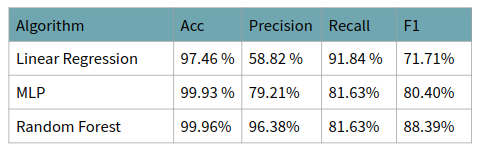

<br/> Dengan pipeline sebagai berikut: <br/>
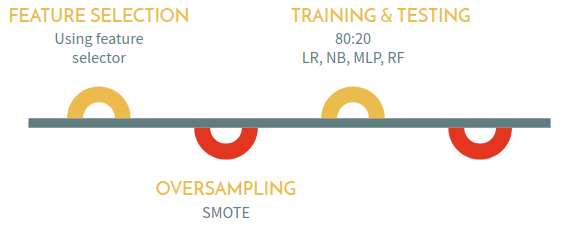


# Import Library

In [ ]:
import tensorflow as tf
assert tf.__version__.startswith('2')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler 
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,precision_recall_fscore_support
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline


from sklearn.model_selection import train_test_split
from IPython.display import clear_output 

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from keras.models import Sequential,clone_model
from keras.layers import Dense,Dropout
import tensorflow as tf 
import tensorflow_addons as tfa
from sklearn.mixture import GaussianMixture

In [2]:
import pandas as pd

# Load Data ke dalam Dataframe

In [3]:
data = pd.read_csv("../data/Credit Card Fraud Detection/creditcard.csv") 

# Exploratory Data Analysis

In [ ]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Deskripsi Fitur

*   Fitur V1 - V28 merupakan fitur hasil PCA. Hal ini dikarenakan terdapat confidentiality dalam data sehingga penyedia data memutuskan untuk men-transformasikan data menggunakan PCA
*   Fitur time merupakan fitur yang menandai kapan sebuah transaksi dilakukan
*   Fitur amount adalah jumlah transaksi yang dilakukan
*   Fitur Class merupakan label yang diprediksi bernilai 0 (bukan fraud) dan 1 (fraud)



## Prosentase kelas terget

In [ ]:
print("Target data yang bernilai fraud adalah {:4f}%".format(sum(data['Class']==1)/len(data)))
print("Target data yang bernilai tidak fraud adalah {:4f}%".format(sum(data['Class']==0)/len(data)))

Target data yang bernilai fraud adalah 0.001727%
Target data yang bernilai tidak fraud adalah 0.998273%


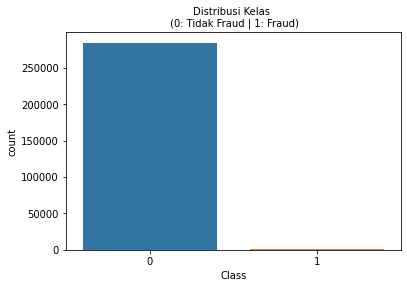

In [ ]:
sns.countplot('Class', data=data)
plt.title('Distribusi Kelas \n (0: Tidak Fraud | 1: Fraud)', fontsize=10)
plt.show()

## Distribusi Fitur Amount

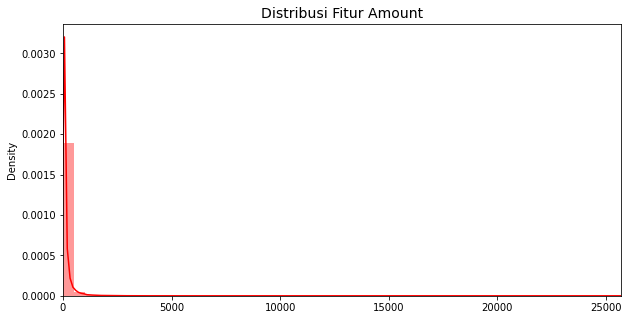

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,5))

sns.distplot(data['Amount'].values, ax=ax, color='r')
ax.set_title('Distribusi Fitur Amount', fontsize=14)
ax.set_xlim([min(data['Amount'].values), max(data['Amount'].values)])
plt.show()

## Distribusi Fitur Time

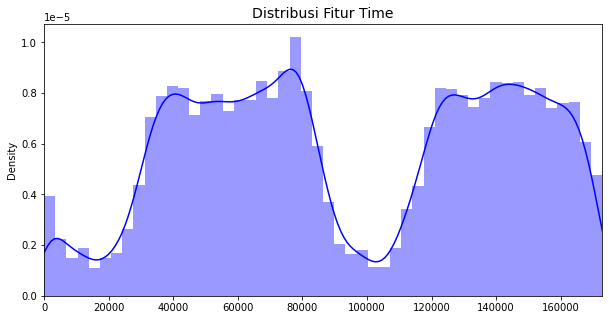

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,5))

sns.distplot(data['Time'].values, ax=ax, color='b')
ax.set_title('Distribusi Fitur Time', fontsize=14)
ax.set_xlim([min(data['Time'].values), max(data['Time'].values)])
plt.show()

## Ukuran Data

In [ ]:
print("Data terdiri dari {} baris dan {} kolom".format(data.shape[0], data.shape[1]))

Data terdiri dari 284807 baris dan 31 kolom


## Periksa Data Duplikat

In [ ]:
print("Prosentasi data duplikat adalah : ",(sum(data.duplicated()) / len(data))*100, "%")

Prosentasi data duplikat adalah :  0.379555277784605 %


## Periksa Data Null

In [ ]:
temp = data.isnull().sum() / len(data)
null_df = pd.DataFrame({'kolom':data.columns.to_list(), 'presentase_data_null (%)':temp.values})

null_df

,kolom,presentase_data_null (%)
0,Time,0.0
1,V1,0.0
2,V2,0.0
3,V3,0.0
4,V4,0.0
5,V5,0.0
6,V6,0.0
7,V7,0.0
8,V8,0.0
9,V9,0.0


Tidak terdapat nilai null pada dataset ini

# Preprocessing

## Menghilangkan baris yang duplikat

In [ ]:
data.drop_duplicates(inplace=True)

## Scaling Fitur Time dan Amount

Robust Scaler <br/>
(xi–Q1(x)) / (Q3(x)–Q1(x))

Penggunaan robust scaler karena metode ini cukup bagus digunakan untuk data yang mengandung outliers. Dibanding MinMax scaler yang menggunakan nilai max dan min. Robust scaler menggunakan IQR untuk scaling data 

In [ ]:
robust_scaler = RobustScaler()

data['Amount_Scaled'] = robust_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['Time_Scaled'] = robust_scaler.fit_transform(data['Time'].values.reshape(-1,1))

# drop kolom awal
data.drop(['Time','Amount'], axis=1, inplace=True)

In [ ]:
# memeriksa apakah data sudah berubah (scaled) dan fitur asal sudah tidak ada di dalam dataset
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount_Scaled,Time_Scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.774718,-0.995290
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.268530,-0.995290
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.959811,-0.995279
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.411487,-0.995279
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.667362,-0.995267


# Split Data

In [ ]:
train, val_test = train_test_split(data,test_size=0.30,random_state=99,stratify=data['Class'])

In [ ]:
val, test = train_test_split(val_test,test_size=0.5,random_state=99,stratify=val_test['Class'])

# Utility Function

In [ ]:
def evalModel(pred,train_real,val_real):
  res_train = precision_recall_fscore_support(train_real, pred[0])
  res_val = precision_recall_fscore_support(val_real, pred[1])
  return pd.DataFrame({'train_precision':[res_train[0][1]],'train_recall':[res_train[1][1]],'train_f1_score':[res_train[2][1]],
                       'val_precision':[res_val[0][1]],'val_recall':[res_val[1][1]],'val_f1_score':[res_val[2][1]]})

In [ ]:
def predictModel(X,y,test,model,parameter={}):
  model.set_params(**parameter)
  model.fit(X,y)
  return model.predict(X),model.predict(test)

In [ ]:
def parameterTuning(x_train,y_train,x_test,y_test,model,tunedParam,values,defaultParam={}):
  result = pd.DataFrame()
  for value in values:
    currParam = defaultParam.copy()
    currParam[tunedParam] = value
    pred = predictModel(x_train,y_train,x_test,model,currParam)
    res = evalModel(pred,y_train,y_test)
    res[tunedParam] = str(value)
    result = pd.concat([result, res], ignore_index=True)
  return result

# Baseline DTL

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=99)
defaultParam = {'criterion':'gini','splitter':'best','max_depth':12,'min_samples_split':2,'max_features':'sqrt','class_weight':{0:1,1:2}}

In [ ]:
x_train = train.drop(['Class'],axis=1)
y_train = train['Class']
x_val = val.drop(['Class'],axis=1)
y_val = val['Class']

In [ ]:
y_pred = predictModel(x_train,y_train,x_val,model,defaultParam)
res = evalModel(y_pred,y_train,y_val)

In [ ]:
res

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score
0,0.983278,0.888218,0.933333,0.803571,0.633803,0.708661


# Sampling

## Under Sampling

In [ ]:
# menerapkan random sample pada data 
data_undersampling = train.sample(frac=1, random_state=2020)

# membuat dataframe yang sama untuk kelas fraud dan non fraud
# menyesuaikan jumlah baris nya dengan data fraud yang berjumlah 492
fraud_data_undersampling = data_undersampling[data_undersampling['Class'] == 1]
non_fraud_data_undersampling = data_undersampling[data_undersampling['Class'] == 0][:492]

normal_distributed_data_undersampling = pd.concat([fraud_data_undersampling, non_fraud_data_undersampling])
new_data_undersampling = normal_distributed_data_undersampling.sample(frac=1, random_state=42)

In [ ]:
new_data_undersampling.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount_Scaled,Time_Scaled
146771,-0.219367,1.195202,-0.515980,-1.135593,1.714713,0.162202,1.493096,-0.644000,0.725667,1.428244,0.200150,0.243498,0.502859,-0.385259,-0.039122,-0.241957,-1.502800,0.855978,0.662749,0.686738,0.107445,1.249861,-0.335029,-0.310792,-0.568698,-0.280486,0.326991,-0.179760,0,-0.293561,0.037400
238466,1.833191,0.745333,-1.133009,3.893556,0.858164,0.910235,-0.498200,0.344703,-0.667939,0.398155,0.613868,-0.022561,0.452018,-2.969201,-0.964967,2.464450,0.671241,1.921021,-1.616927,-0.085579,0.039289,0.181652,0.072981,-0.155299,-0.149891,0.012792,0.040854,0.022903,1,-0.064108,0.763674
6717,-1.813280,4.917851,-5.926130,5.701500,1.204393,-3.035138,-1.713402,0.561257,-3.796354,-7.454841,7.388055,-10.475229,-0.379315,-11.736729,-2.086989,-2.442354,-3.535524,0.130360,-2.071450,0.576656,0.615642,-0.406427,-0.737018,-0.279642,1.106766,0.323885,0.894767,0.569519,1,-0.292032,-0.896481
33276,-7.923891,-5.198360,-3.000024,4.420666,2.272194,-3.394483,-5.283435,0.131619,0.658176,-0.794994,3.266066,-2.719185,-0.124104,-5.274866,0.638575,-2.995830,-4.698433,-1.711871,3.025261,-2.169811,-0.734308,-0.599926,-4.908301,0.410170,-1.167660,0.520508,1.937421,-1.552593,1,-0.134752,-0.558511
140786,-0.433222,2.428379,-3.996454,4.871299,-1.796308,-0.586868,-4.654543,1.285230,-2.743539,-5.638941,4.343743,-6.655734,-0.293109,-9.505141,-1.396149,-4.850323,-10.006253,-2.789598,0.982584,0.745029,0.713559,-0.408954,-0.320890,-0.804230,0.962852,0.199558,1.094533,0.541148,1,-0.292032,-0.008914


In [ ]:
model = DecisionTreeClassifier(random_state=99)
defaultParam = {'criterion':'gini','splitter':'best','max_depth':12,'min_samples_split':2,'max_features':'sqrt','class_weight':{0:1,1:2}}

x_train = new_data_undersampling.drop(['Class'],axis=1)
y_train = new_data_undersampling['Class']
x_val = val.drop(['Class'],axis=1)
y_val = val['Class']

y_pred = predictModel(x_train,y_train,x_val,model,defaultParam)

evalModel(y_pred,y_train,y_val)

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score
0,1.0,1.0,1.0,0.020612,0.929577,0.04033


## SMOTE

In [ ]:
x_train = train.drop(['Class'],axis=1)
y_train = train['Class']

In [ ]:
sm = SMOTE(sampling_strategy='minority', random_state=2020)
smote_X_train, smote_y_train = sm.fit_resample(x_train, y_train)

Sekarang persebaran data sudah sesuai baik untuk kelas fraud atau pun non fraud

In [ ]:
model = DecisionTreeClassifier(random_state=99)
defaultParam = {'criterion':'gini','splitter':'best','max_depth':12,'min_samples_split':2,'max_features':'sqrt','class_weight':{0:1,1:2}}

x_val = val.drop(['Class'],axis=1)
y_val = val['Class']

y_pred = predictModel(smote_X_train,smote_y_train,x_val,model,defaultParam)

evalModel(y_pred,smote_y_train,y_val)

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score
0,0.98661,0.997438,0.991995,0.089764,0.802817,0.161473


## Analisis

Berikut perbandingan metrik pada beberapa variasi data:

|               | train_precision | train_recall | train_f1_score | val_precision | val_recall | val_f1_score |
|---------------|-----------------|--------------|----------------|---------------|------------|--------------|
| Baseline      | 0.983278        | 0.888218     | 0.933333       | 0.803571      | 0.633803   | 0.708661     |
| Undersampling | 1.0             | 1.0          | 1.0            | 0.020612      | 0.929577   | 0.04033      |
| SMOTE         | 0.98661         | 0.997438     | 0.991995       | 0.089764      | 0.802817   | 0.161473     |

Data baseline mendapatkan performa terbaik jika dibandingkan dengan teknik undersampling dan SMOTE yang sangat overfit. Penggunaan undersampling membuat data yang awalnya ratusan ribu baris menjadi hanya 984 baris. Hal ini menyebabkan model tidak bisa dilatih dengan baik karena data yang terlalu sedikit. Penggunaan teknik SMOTE untuk oversampling data training juga mengalami overfit. Hal ini dikarenakan perbedaan pada frekuensi kelas train dan val. Dengan oversampling pada data training yang tidak tepat dapat mengakibatkan decision boundary yang dibuat saat model dilatih tidak dapat mengklasifikasikan dengan baik saat memprediksi data validation yang memiliki frekuensi label yang berbeda.

# Seleksi Fitur

## Korelasi Dengan Target

In [ ]:
korelasi = train.corr()['Class'].abs().sort_values(ascending=False)
pd.DataFrame(korelasi).rename({'Class':'Korelasi'},axis=1)

,Korelasi
Class,1.000000
V17,0.322909
V14,0.300002
V12,0.258538
V10,0.209968
V16,0.191752
V3,0.186850
V7,0.172618
V11,0.153502
V4,0.132734


In [ ]:
def tunnedFeature(x_train,y_train,x_test,y_test,model,feature,values,defaultParam):
  result = pd.DataFrame()
  for value in values:
    pred = predictModel(x_train[feature[:value]],y_train,x_test[feature[:value]],model,defaultParam)
    res = evalModel(pred,y_train,y_test)
    res['Jumlah Fitur'] = str(value)
    result = pd.concat([result, res], ignore_index=True)
  return result

In [ ]:
model = DecisionTreeClassifier(random_state=99)
defaultParam = {'criterion':'gini','splitter':'best','max_depth':12,'min_samples_split':2,'max_features':'sqrt','class_weight':{0:1,1:2}}

In [ ]:
%%time
x_train = train.drop(['Class'],axis=1)
y_train = train['Class']
x_val = val.drop(['Class'],axis=1)
y_val = val['Class']
feature = korelasi.index.values[1:]
values = [27,25,23,20,17,15]

CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 16.1 ms


In [ ]:
res = tunnedFeature(x_train,y_train,x_val,y_val,model,feature,values,defaultParam)
res

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score,Jumlah Fitur
0,0.996633,0.894260,0.942675,0.839286,0.661972,0.740157,27
1,0.986111,0.858006,0.917609,0.901961,0.647887,0.754098,25
2,1.000000,0.867069,0.928803,0.918367,0.633803,0.750000,23
3,0.996795,0.939577,0.967341,0.865385,0.633803,0.731707,20
4,0.972509,0.854985,0.909968,0.854545,0.661972,0.746032,17
5,0.974277,0.915408,0.943925,0.830508,0.690141,0.753846,15


## PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def tunnedPCA(x_train,y_train,x_test,y_test,model,values,defaultParam):
  result = pd.DataFrame()
  for value in values:
    pca = PCA(n_components=value)
    x_pca_train = pca.fit_transform(x_train)
    x_pca_test = pca.transform(x_test)
    
    pred = predictModel(x_pca_train,y_train,x_pca_test,model,defaultParam)
    res = evalModel(pred,y_train,y_test)
    res['Jumlah Fitur'] = str(value)
    result = pd.concat([result, res], ignore_index=True)
    
  return result

In [ ]:
model = DecisionTreeClassifier(random_state=99)
defaultParam = {'criterion':'gini','splitter':'best','max_depth':12,'min_samples_split':2,'max_features':'sqrt','class_weight':{0:1,1:2}}

In [ ]:
%%time
x_train = train.drop(['Class'],axis=1)
y_train = train['Class']
x_val = val.drop(['Class'],axis=1)
y_val = val['Class']
values = [27,25,23,20,17,15]

CPU times: user 17.2 ms, sys: 0 ns, total: 17.2 ms
Wall time: 18.7 ms


In [ ]:
res = tunnedPCA(x_train,y_train,x_val,y_val,model,values,defaultParam)
res

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score,Jumlah Fitur
0,0.986348,0.873112,0.926282,0.883333,0.746479,0.809160,27
1,0.979730,0.876133,0.925040,0.868852,0.746479,0.803030,25
2,0.993266,0.891239,0.939490,0.786885,0.676056,0.727273,23
3,0.996587,0.882175,0.935897,0.862069,0.704225,0.775194,20
4,0.958042,0.827795,0.888169,0.807692,0.591549,0.682927,17
5,0.993485,0.921450,0.956113,0.816667,0.690141,0.748092,15


## ICA

In [ ]:
from sklearn.decomposition import FastICA

In [ ]:
def tunnedICA(x_train,y_train,x_test,y_test,model,values,defaultParam):
  result = pd.DataFrame()
  for value in values:
    ica = FastICA(n_components=value)
    x_ica_train = ica.fit_transform(x_train)
    x_ica_test = ica.transform(x_test)
    
    pred = predictModel(x_ica_train,y_train,x_ica_test,model,defaultParam)
    res = evalModel(pred,y_train,y_test)
    res['Jumlah Fitur'] = str(value)
    result = pd.concat([result, res], ignore_index=True)
    
  return result

In [ ]:
%%time
x_train = train.drop(['Class'],axis=1)
y_train = train['Class']
x_val = val.drop(['Class'],axis=1)
y_val = val['Class']
values = [27,25,23,20,17,15]

CPU times: user 17.7 ms, sys: 0 ns, total: 17.7 ms
Wall time: 17.6 ms


In [ ]:
res = tunnedICA(x_train,y_train,x_val,y_val,model,values,defaultParam)
res

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score,Jumlah Fitur
0,0.986971,0.915408,0.949843,0.796610,0.661972,0.723077,27
1,0.989619,0.864048,0.922581,0.833333,0.704225,0.763359,25
2,0.996479,0.854985,0.920325,0.875000,0.690141,0.771654,23
3,0.986622,0.891239,0.936508,0.742857,0.732394,0.737589,20
4,0.990683,0.963746,0.977029,0.857143,0.676056,0.755906,17
5,0.987055,0.921450,0.953125,0.826923,0.605634,0.699187,15


## Bandingkan Semua Teknik Seleksi Fitur

In [ ]:
x_train = train.drop(['Class'],axis=1)
y_train = train['Class']
x_test = test.drop(['Class'],axis=1)
y_test = test['Class']

In [ ]:
result = pd.DataFrame()
pred = predictModel(x_train,y_train,x_test,model,defaultParam)
res = evalModel(pred,y_train,y_test)
res['Jumlah Fitur'] = str(len(x_train.columns))
res['Teknik'] = 'Baseline'
result = pd.concat([result, res], ignore_index=True)

# Teknik Korelasi dengan target
value = 25
pred = predictModel(x_train[feature[:value]],y_train,x_test[feature[:value]],model,defaultParam)
res = evalModel(pred,y_train,y_test)
res['Jumlah Fitur'] = str(value)
res['Teknik'] = 'Korelasi dengan target'
result = pd.concat([result, res], ignore_index=True)

# Teknik PCA
value = 27
pca = PCA(n_components=value)
x_pca_train = pca.fit_transform(x_train)
x_pca_test = pca.transform(x_test)

pred = predictModel(x_pca_train,y_train,x_pca_test,model,defaultParam)
res = evalModel(pred,y_train,y_test)
res['Jumlah Fitur'] = str(value)
res['Teknik'] = 'PCA'
result = pd.concat([result, res], ignore_index=True)

# Teknik ICA
value = 15
ica = FastICA(n_components=value)
x_ica_train = ica.fit_transform(x_train)
x_ica_test = ica.transform(x_test)
    
pred = predictModel(x_ica_train,y_train,x_ica_test,model,defaultParam)
res = evalModel(pred,y_train,y_test)
res['Jumlah Fitur'] = str(value)
res['Teknik'] = 'ICA'
result = pd.concat([result, res], ignore_index=True)

In [ ]:
result

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score,Jumlah Fitur,Teknik
0,0.983278,0.888218,0.933333,0.875000,0.690141,0.771654,30,Baseline
1,0.986111,0.858006,0.917609,0.842105,0.676056,0.750000,25,Korelasi dengan target
2,0.986348,0.873112,0.926282,0.890909,0.690141,0.777778,27,PCA
3,0.977346,0.912387,0.943750,0.742857,0.732394,0.737589,15,ICA


Metode  pengambilan fitur berdasarkan PCA mendapatkan hasil terbaik dengan jumlah fitur 27. Hal tersebut menunjukan bahwa adanya permasalahan curse of dimensionality untuk problem ini sehingga menyebabkan kinerja model menurun. Dengan mengurangi fitur diharapkan model lebih robust sehingga terhindar dari masalah overfitting.

# Modeling

### XGB Classifier

In [ ]:
model = XGBClassifier()

#### Baseline

In [ ]:
# xgboost baseline
value = 27

pca = PCA(n_components=value)
x_train = pca.fit_transform(train.drop(['Class'],axis=1))
x_val = pca.transform(val.drop(['Class'],axis=1))

pred = predictModel(x_train,y_train,x_val,model,{})
evalModel(pred,y_train,y_val)

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score
0,1.0,0.996979,0.998487,0.923077,0.676056,0.780488


#### Tuning scale_pos_weight

In [ ]:
#dari hasil diatas 
tunedParam = 'scale_pos_weight'
values = [2, 2.2, 2.4]
parameterTuning(x_train,y_train,x_val,y_val,model,tunedParam,values,defaultParam={})

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score,scale_pos_weight
0,1.0,0.993958,0.996970,0.872727,0.676056,0.761905,2
1,1.0,0.993958,0.996970,0.907407,0.690141,0.784000,2.2
2,1.0,0.996979,0.998487,0.923077,0.676056,0.780488,2.4


#### Tuning max_depth

In [ ]:
tunedParam = 'max_depth'
values = [3, 6, 11]
defaultParam = {'scale_pos_weight':2.2}
parameterTuning(x_train,y_train,x_val,y_val,model,tunedParam,values,defaultParam)

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score,max_depth
0,0.909968,0.854985,0.881620,0.838710,0.732394,0.781955,3
1,0.993921,0.987915,0.990909,0.888889,0.676056,0.768000,6
2,1.000000,1.000000,1.000000,0.890909,0.690141,0.777778,11


#### Tuning min_child_weight

In [ ]:
tunedParam = 'min_child_weight'
values = [1 , 5, 11]
defaultParam = {'scale_pos_weight':2.2, 'max_depth':3}
parameterTuning(x_train,y_train,x_val,y_val,model,tunedParam,values,defaultParam)

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score,min_child_weight
0,0.916129,0.858006,0.886115,0.844828,0.690141,0.759690,1
1,0.922078,0.858006,0.888889,0.890909,0.690141,0.777778,5
2,0.895238,0.851964,0.873065,0.809524,0.718310,0.761194,11


#### Tuning gamma

In [ ]:
tunedParam = 'gamma'
values = [0.0 , 0.1, 0.2]
defaultParam = {'scale_pos_weight':2.2, 'max_depth':3, 'min_child_weight':5}
parameterTuning(x_train,y_train,x_val,y_val,model,tunedParam,values,defaultParam)

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score,gamma
0,0.922078,0.858006,0.888889,0.890909,0.690141,0.777778,0.0
1,0.925325,0.861027,0.892019,0.888889,0.676056,0.768000,0.1
2,0.899054,0.861027,0.879630,0.813559,0.676056,0.738462,0.2


#### Tuning subsample

In [ ]:
tunedParam = 'subsample'
values = [0.8, 1]
defaultParam = {'scale_pos_weight':2.2, 'max_depth':3, 'min_child_weight':5, 'gamma':0}
parameterTuning(x_train,y_train,x_val,y_val,model,tunedParam,values,defaultParam)

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score,subsample
0,0.922078,0.858006,0.888889,0.900000,0.760563,0.824427,0.8
1,0.922078,0.858006,0.888889,0.890909,0.690141,0.777778,1


#### Tuning reg_alpha

In [ ]:
tunedParam = 'reg_alpha'
values = [0, 0.005, 0.05]
defaultParam = {'scale_pos_weight':2.2, 'max_depth':3, 'min_child_weight':5, 'gamma':0, 'subsample':0.8}
parameterTuning(x_train,y_train,x_val,y_val,model,tunedParam,values,defaultParam)

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score,reg_alpha
0,0.922078,0.858006,0.888889,0.900000,0.760563,0.824427,0
1,0.925081,0.858006,0.890282,0.900000,0.760563,0.824427,0.005
2,0.927869,0.854985,0.889937,0.898305,0.746479,0.815385,0.05


### Artificial Neural Network

## ANN 1

In [ ]:
# xgboost baseline
value = 27

pca = PCA(n_components=value)
x_train = pca.fit_transform(train.drop(['Class'],axis=1))
x_val = pca.transform(val.drop(['Class'],axis=1))

In [ ]:
def makeANN(input,hidden_layer_size,dropout=0):
  model = Sequential()
  model.add(Dense(units = hidden_layer_size[0], activation = 'relu', input_dim = input))
  for i in hidden_layer_size[1:]: 
    model.add(Dense(units = i, activation = 'relu'))
  model.add(Dropout(dropout))
  model.add(Dense(units = 1,  activation = 'sigmoid'))
  return model

In [ ]:
classifier = makeANN(x_train.shape[1],[64,32,16,8])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1792      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
____________________________________________________

### Tuning Learning Rate

In [ ]:
classifier.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), loss = 'binary_crossentropy', metrics = [tfa.metrics.FBetaScore(num_classes=2,average="micro",threshold=0.5)])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 10))

history = classifier.fit(x_train, y_train, batch_size = 128, epochs = 40,validation_data=(x_val,y_val), callbacks=[lr_schedule],verbose=0)

(1e-05, 0.1, 0.0, 0.02)

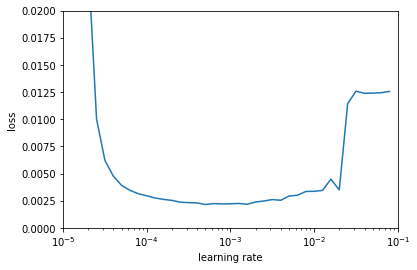

In [ ]:
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 0.02])

### Tuning Epochs

In [ ]:
classifier = makeANN(x_train.shape[1],[64,32,16,8])
classifier.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=3*1e-4), loss = 'binary_crossentropy', metrics = [tfa.metrics.FBetaScore(num_classes=2,average="micro",threshold=0.5)])
history = classifier.fit(x_train, y_train, batch_size = 128, epochs = 30,validation_data=(x_val,y_val),verbose=0)

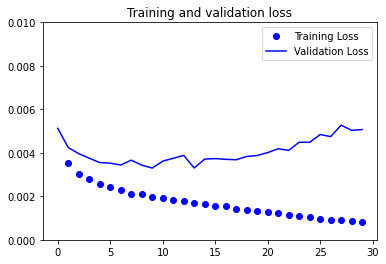

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend() 
plt.ylim(0, 0.01) 
plt.show()

### Tuning weight

In [ ]:
def tunnedWeight(x_train,y_train,x_test,y_test,model,values,lr,epoch):
  result = pd.DataFrame()
  for value in values:
    classifier = tf.keras.models.clone_model(model)
    classifier.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr), loss = 'binary_crossentropy', metrics = [tfa.metrics.FBetaScore(num_classes=2,average="micro",threshold=0.5)])
    classifier.fit(x_train, y_train,class_weight=value, batch_size = 128, epochs = epoch,verbose=0)
    
    y_pred_test = (classifier.predict(x_test).T[0] > 0.5).astype(int)
    y_pred_train = (classifier.predict(x_train).T[0] > 0.5).astype(int)

    res = evalModel((y_pred_train,y_pred_test),y_train,y_test)
    res['Weight'] = str(value)
    result = pd.concat([result, res], ignore_index=True)
    
  return result

In [ ]:
parameter = [{0:5, 1:1},{0:2, 1:1}, {0:1, 1:1}, {0:1, 1:2},{0:1,1:5}]
lr = 3*1e-4
epoch = 12
res = tunnedWeight(x_train,y_train,x_val,y_val,makeANN(x_train.shape[1],[64,32,16,8]),parameter,lr,epoch)
res

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score,Weight
0,0.995595,0.682779,0.810036,0.954545,0.591549,0.730435,"{0: 5, 1: 1}"
1,0.968641,0.839879,0.899676,0.924528,0.690141,0.790323,"{0: 2, 1: 1}"
2,0.970260,0.788520,0.870000,0.879310,0.718310,0.790698,"{0: 1, 1: 1}"
3,0.795213,0.903323,0.845827,0.743243,0.774648,0.758621,"{0: 1, 1: 2}"
4,0.733496,0.906344,0.810811,0.682927,0.788732,0.732026,"{0: 1, 1: 5}"


## ANN 2

In [ ]:
classifier = makeANN(x_train.shape[1],[15,10],0.2)
classifier.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 15)                420       
_________________________________________________________________
dense_21 (Dense)             (None, 10)                160       
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 11        
Total params: 591
Trainable params: 591
Non-trainable params: 0
_________________________________________________________________


### Tuning Learning Rate

In [ ]:
classifier.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), loss = 'binary_crossentropy', metrics = [tfa.metrics.FBetaScore(num_classes=2,average="micro",threshold=0.5)])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 10))

history = classifier.fit(x_train, y_train, batch_size = 128, epochs = 40,validation_data=(x_val,y_val), callbacks=[lr_schedule],verbose=0)

(1e-05, 0.1, 0.0, 0.02)

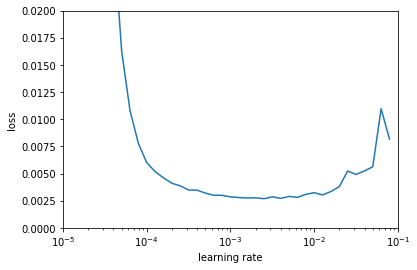

In [ ]:
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 0.02])

### Tuning Epochs

In [ ]:
classifier = makeANN(x_train.shape[1],[15,10],0.2)
classifier.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), loss = 'binary_crossentropy', metrics = [tfa.metrics.FBetaScore(num_classes=2,average="micro",threshold=0.5)])
history = classifier.fit(x_train, y_train, batch_size = 128, epochs = 30,validation_data=(x_val,y_val),verbose=0)

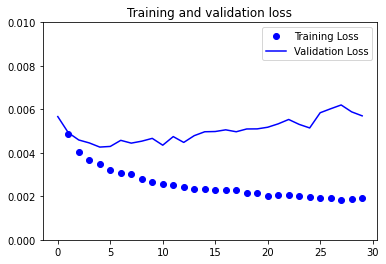

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend() 
plt.ylim(0, 0.01) 
plt.show()

### Tuning weight

In [ ]:
lr = 1e-3
epoch = 15
res = tunnedWeight(x_train,y_train,x_val,y_val,makeANN(x_train.shape[1],[15,10],0.2),parameter,lr,epoch)
res

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score,Weight
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"{0: 5, 1: 1}"
1,0.939163,0.746224,0.831650,0.940000,0.661972,0.776860,"{0: 2, 1: 1}"
2,0.906250,0.788520,0.843296,0.881356,0.732394,0.800000,"{0: 1, 1: 1}"
3,0.876972,0.839879,0.858025,0.774648,0.774648,0.774648,"{0: 1, 1: 2}"
4,0.818444,0.858006,0.837758,0.779412,0.746479,0.762590,"{0: 1, 1: 5}"


## GMM

In [ ]:
value = 27
pca = PCA(n_components=value)

x_train = pca.fit_transform(train.drop(['Class'],axis=1))
x_train0 = pca.transform(train[train['Class'] == 0].drop(['Class'],axis=1))
x_val = pca.transform(val.drop(['Class'],axis=1))
y_train = train['Class']
y_val = val['Class']


In [ ]:
model = GaussianMixture(n_components=4).fit(x_train0)

### Tuning Threshold

In [ ]:
def tuningThreshold(x_train,x_test,y_train,y_test,model,values):
  result = pd.DataFrame()
  for value in values:
    pred_train = model.score_samples(x_train)
    pred_train = (pred_train < value).astype(int)

    pred_test = model.score_samples(x_test)
    pred_test = (pred_test < value).astype(int)

    res = evalModel((pred_train,pred_test),y_train,y_test)
    res["Threshold Score"] = str(value)
    result = pd.concat([result, res], ignore_index=True)
  return result

In [ ]:
values = [-500,-350,-200,-150,-100]
tuningThreshold(x_train,x_val,y_train,y_val,model,values)

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score,Threshold Score
0,0.834008,0.622356,0.712803,0.787234,0.521127,0.627119,-500
1,0.831502,0.685801,0.751656,0.800000,0.619718,0.698413,-350
2,0.798722,0.755287,0.776398,0.770492,0.661972,0.712121,-200
3,0.740113,0.791541,0.764964,0.704225,0.704225,0.704225,-150
4,0.625882,0.803625,0.703704,0.565217,0.732394,0.638037,-100


# Test Model

In [ ]:
value = 27

pca = PCA(n_components=value)
x_train = pca.fit_transform(train.drop(['Class'],axis=1))
x_train0 = pca.transform(train[train['Class'] == 0].drop(['Class'],axis=1))
x_test = pca.transform(test.drop(['Class'],axis=1))

In [ ]:
result = pd.DataFrame()

# XGBClassifier
model = XGBClassifier()
param = {'scale_pos_weight':2.2, 'max_depth':3, 'min_child_weight':5, 'gamma':0, 'subsample':0.8,'reg_alpha':0}

pred = predictModel(x_train,y_train,x_test,model,param)
res = evalModel(pred,y_train,y_test)
res['Model'] = 'XGBClassifier'
result = pd.concat([result, res], ignore_index=True)

# ANN 1
model = makeANN(x_train.shape[1],[64,32,16,8])
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=3*1e-4), loss = 'binary_crossentropy', metrics = [tfa.metrics.FBetaScore(num_classes=2,average="micro",threshold=0.5)])
model.fit(x_train, y_train,class_weight={0:1, 1:1}, batch_size = 128, epochs = 12,verbose=0)

y_pred_train = (model.predict(x_train)>0.5).astype(int)
y_pred_test = (model.predict(x_test)>0.5).astype(int)
res = evalModel((y_pred_train,y_pred_test),y_train,y_test)
res['Model'] = 'ANN 1'
result = pd.concat([result, res], ignore_index=True)

# ANN 2
model = makeANN(x_train.shape[1],[15,10],0.2)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), loss = 'binary_crossentropy', metrics = [tfa.metrics.FBetaScore(num_classes=2,average="micro",threshold=0.5)])
model.fit(x_train, y_train,class_weight={0:1, 1:1}, batch_size = 128, epochs = 15,verbose=0)

y_pred_train = (model.predict(x_train)>0.5).astype(int)
y_pred_test = (model.predict(x_test)>0.5).astype(int)
res = evalModel((y_pred_train,y_pred_test),y_train,y_test)
res['Model'] = 'ANN 2'
result = pd.concat([result, res], ignore_index=True)

# GMM
model = GaussianMixture(n_components=4).fit(x_train0)
value = -200

pred_train = model.score_samples(x_train)
y_pred_train = (pred_train < value).astype(int)
pred_test = model.score_samples(x_test)
y_pred_test = (pred_test < value).astype(int)
res = evalModel((y_pred_train,y_pred_test),y_train,y_test)
res['Model'] = 'GMM'
result = pd.concat([result, res], ignore_index=True)

In [ ]:
result.set_index('Model')

,train_precision,train_recall,train_f1_score,val_precision,val_recall,val_f1_score
Model,,,,,,
XGBClassifier,0.927869,0.854985,0.889937,0.774648,0.774648,0.774648
ANN 1,0.878125,0.848943,0.863287,0.770270,0.802817,0.786207
ANN 2,0.892617,0.803625,0.845787,0.797101,0.774648,0.785714
GMM,0.798722,0.755287,0.776398,0.731343,0.690141,0.710145


Didapatkan model terbaik yaitu ANN yang memiliki layer yang lebih dalam dengan f1-score sebesar 0.7862